In [8]:
from src.pytorch_datasets import DAPSAudioDataset_with_cropping
import os
from torch.utils.data import DataLoader, Subset

import torch

audio_dir = "daps_2"

class_1_speakers = ["f1", "f7", "f8", "m3", "m6", "m8"]

class_mapping = {}

for root, dirs, files in os.walk('precomputed_spectrograms_aug'):
    for file in files:
        audio_path = os.path.join(root, file)
        try:
            speaker_prefix = file.split("_")[0]
            if speaker_prefix in class_1_speakers:
                class_mapping[audio_path] = 1
            else:
                class_mapping[audio_path] = 0
        except Exception as e:
            print(f"Error processing {audio_path}: {e}")

print("Class mapping created:")

class_0_count = sum(1 for label in class_mapping.values() if label == 0)
class_1_count = sum(1 for label in class_mapping.values() if label == 1)
print(f"Total Class 0 samples: {class_0_count}")
print(f"Total Class 1 samples: {class_1_count}")
print("Preparing the dataset...")

full_dataset = DAPSAudioDataset_with_cropping(class_mapping=class_mapping)

test_ids =[]
train_ids =[]
filenames = set()
for idx in range(len(full_dataset)):
    path, label = full_dataset.class_mapping[idx]
    if path is not None:
        filename = os.path.basename(path)
            
        filename_without_ext = os.path.splitext(filename)[0]
        parts = filename_without_ext.split('_')
            
        group = parts[0]
        place = ""
        if 'script1' in filename_without_ext:
            if 'aug' not in filename_without_ext:
                filenames.add(place)
                test_ids.append(idx)
            else: 
                continue
        else:
            train_ids.append(idx) 

            
print(len(test_ids))
print(len(train_ids))

print("Dataset created")

train_dataset = Subset(full_dataset, train_ids)
test_dataset = Subset(full_dataset, test_ids)

def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None
    return torch.utils.data.dataloader.default_collate(batch)


train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn
)

for batch in train_loader:
    inputs, labels = batch
    print(f"Train Inputs shape: {inputs.shape}")
    print(f"Train Labels: {labels}")
    break

for batch in test_loader:
    inputs, labels = batch
    print(f"Test Inputs shape: {inputs.shape}")
    print(f"Test Labels: {labels}")
    break



Class mapping created:
Total Class 0 samples: 1050
Total Class 1 samples: 1350
Preparing the dataset...
300
1920
Dataset created


c:\Users\cypri\VoiceRecognition\src\pytorch_datasets.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  spectrogram_tensor = torch.load(spectrogram_path)


Train Inputs shape: torch.Size([64, 1, 64, 64])
Train Labels: tensor([0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0])
Test Inputs shape: torch.Size([16, 1, 64, 64])
Test Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])


In [2]:
import torch
import multiprocessing

torch.set_num_threads(4)

print("Nombre de cœurs physiques:", multiprocessing.cpu_count())

logical_cores = torch.get_num_threads()
print("Nombre de cœurs logiques (threads disponibles):", logical_cores)

Nombre de cœurs physiques: 12
Nombre de cœurs logiques (threads disponibles): 4


In [3]:
train_loader

Epoch 1/3, start training...
Epoch [1/3], Loss: 0.9857
Epoch 2/3, start training...
Epoch [2/3], Loss: 0.7391
Epoch 3/3, start training...
Epoch [3/3], Loss: 0.6402


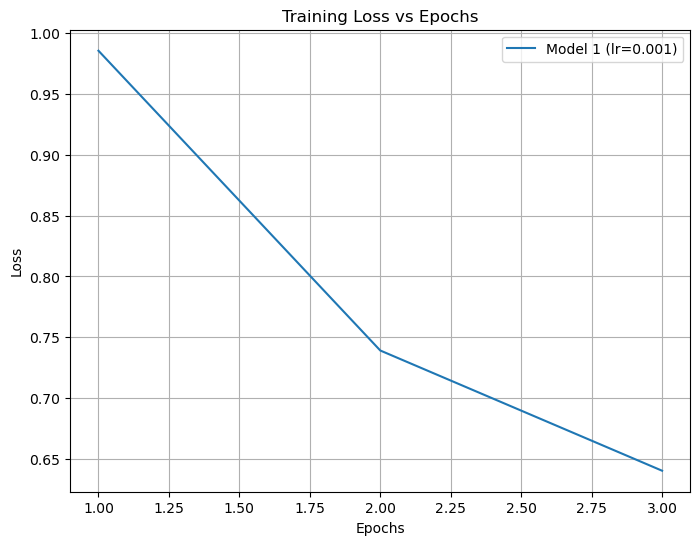

In [4]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


freq_bins = 64
time_steps = 64
lr = 0.001

model = Net(freq_bins, time_steps).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


num_epochs = 3
batch_size = 32  

optimizer_name = type(optimizer).__name__

metadata = {
    "model": str(model),
    "freq_bins": freq_bins,
    "time_steps": time_steps,
    "batch_size": batch_size,
    "train_set_size": len(train_loader.dataset),
    "optimizer": optimizer_name,
    "loss_function": str(criterion),
    "num_epochs": num_epochs,
}

timestamp = time.strftime("%S-%M-%H-%d-%m-%Y")
results_path = f"models_results/{num_epochs}x{lr}x{optimizer_name}x{len(train_loader.dataset)}_{timestamp}.json"
os.makedirs(os.path.dirname(results_path), exist_ok=True)


training_results = {"metadata": metadata, "data": {}}


for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}, start training...")
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)

    epoch_data = {"loss": avg_loss, "lr": optimizer.param_groups[0]["lr"]}
    training_results["data"][str(epoch + 1)] = epoch_data

    with open(results_path, "w") as f:
        json.dump(training_results, f, indent=4)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")


fig, ax = plt.subplots(figsize=(8, 6))


plot_training_results(ax, results_path, label_prefix="Model 1")


plt.title("Training Loss vs Epochs")
plt.show()

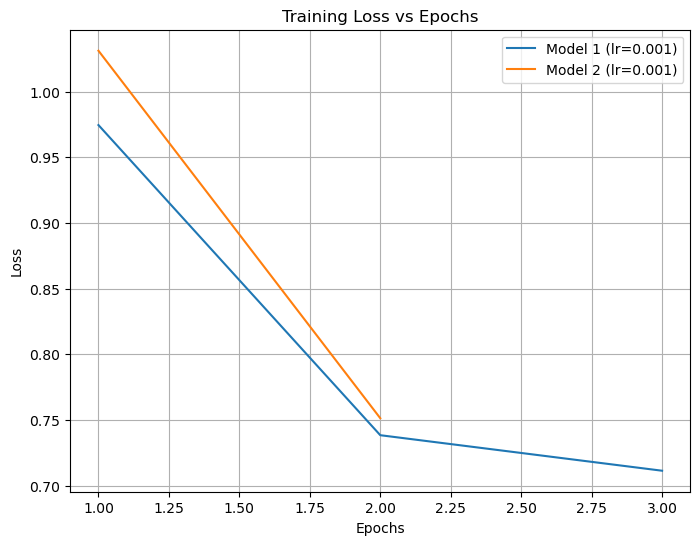

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "3x0.001xAdamx1920_13-12-02-10-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Model 1")
results_path = "models_results/" + "2x0.001xAdamx1920_55-05-02-10-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Model 2")


plt.title("Training Loss vs Epochs")
plt.show()

In [9]:
len(train_loader.dataset)

1920

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

freq_bins = 64
time_steps = 64

# Configurations for your task
configs = [
    {"lr": 0.0001, "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)},
    {"lr": 0.001, "optimizer": lambda model: optim.SGD(model.parameters(), lr=0.001, momentum=0.9)},
]

num_epochs = 30
batch_size = 32

# Loop over configurations
for config in configs:
    lr = config["lr"]
    optimizer = config["optimizer"]

    model = Net(freq_bins, time_steps).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_instance = optimizer(model)

    optimizer_name = type(optimizer_instance).__name__

    metadata = {
        "model": str(model),
        "freq_bins": freq_bins,
        "time_steps": time_steps,
        "batch_size": batch_size,
        "optimizer": optimizer_name,
        "loss_function": str(criterion),
        "num_epochs": num_epochs,
    }

    timestamp = time.strftime("%S-%M-%H-%d-%m-%Y")
    results_path = f"models_results/{num_epochs}x{lr}x{optimizer_name}x{len(train_loader.dataset)}_{timestamp}.json"
    os.makedirs(os.path.dirname(results_path), exist_ok=True)

    training_results = {"metadata": metadata, "data": {}}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}, start training with lr={lr}...")

        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer_instance.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer_instance.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)

        epoch_data = {"loss": avg_loss, "lr": optimizer_instance.param_groups[0]["lr"]}
        training_results["data"][str(epoch + 1)] = epoch_data

        with open(results_path, "w") as f:
            json.dump(training_results, f, indent=4)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    print(f"Results saved in: {results_path}")

Epoch 1/30, start training with lr=0.0001...
Epoch [1/30], Loss: 2.1284
Epoch 2/30, start training with lr=0.0001...
Epoch [2/30], Loss: 1.7115
Epoch 3/30, start training with lr=0.0001...
Epoch [3/30], Loss: 1.3130
Epoch 4/30, start training with lr=0.0001...
Epoch [4/30], Loss: 1.0348
Epoch 5/30, start training with lr=0.0001...
Epoch [5/30], Loss: 0.9109
Epoch 6/30, start training with lr=0.0001...
Epoch [6/30], Loss: 0.8619
Epoch 7/30, start training with lr=0.0001...
Epoch [7/30], Loss: 0.8132
Epoch 8/30, start training with lr=0.0001...
Epoch [8/30], Loss: 0.7932
Epoch 9/30, start training with lr=0.0001...
Epoch [9/30], Loss: 0.7734
Epoch 10/30, start training with lr=0.0001...
Epoch [10/30], Loss: 0.7774
Epoch 11/30, start training with lr=0.0001...
Epoch [11/30], Loss: 0.7519
Epoch 12/30, start training with lr=0.0001...
Epoch [12/30], Loss: 0.7356
Epoch 13/30, start training with lr=0.0001...
Epoch [13/30], Loss: 0.7302
Epoch 14/30, start training with lr=0.0001...
Epoch [14/

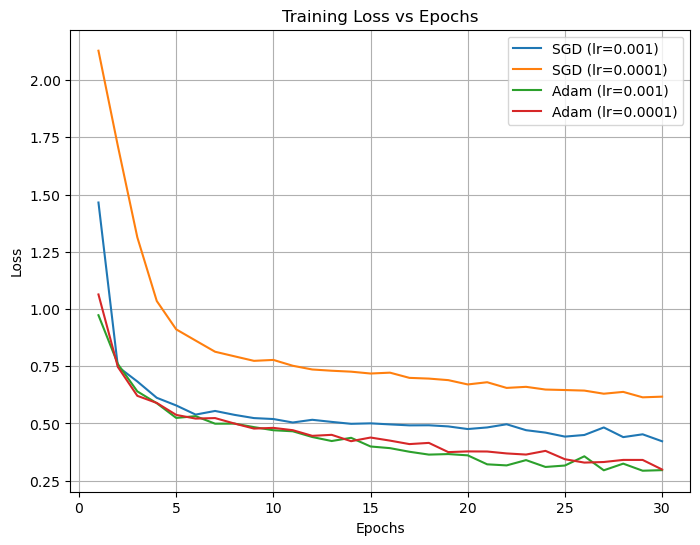

In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from src import Net
import json
import os
import matplotlib.pyplot as plt
from src import plot_training_results
import time

fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "30x0.001xSGD_results_00-11-23-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="SGD")
results_path = "models_results/" + "30x0.0001xSGD_results_27-45-22-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="SGD")
results_path = "models_results/" + "30x0.001xAdamx1560_51-07-19-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Adam")
results_path = "models_results/" + "30x0.0001xAdamx1560_08-50-18-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="Adam")

plt.title("Training Loss vs Epochs")
plt.show()

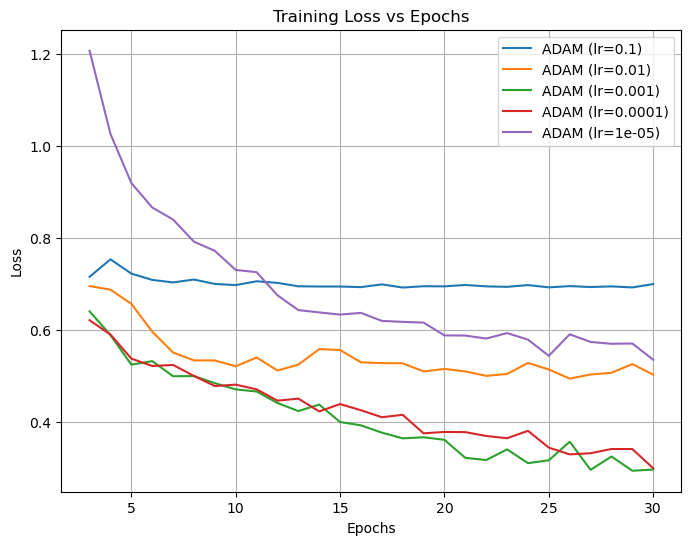

In [6]:
fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "30x0.1xAdamx1560_12-24-20-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x0.01xAdamx1560_12-57-19-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x0.001xAdamx1560_51-07-19-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x0.0001xAdamx1560_08-50-18-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)
results_path = "models_results/" + "30x1e-05xAdamx1560_00-29-18-26-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM", start_epoch=3)

plt.title("Training Loss vs Epochs")
plt.show()

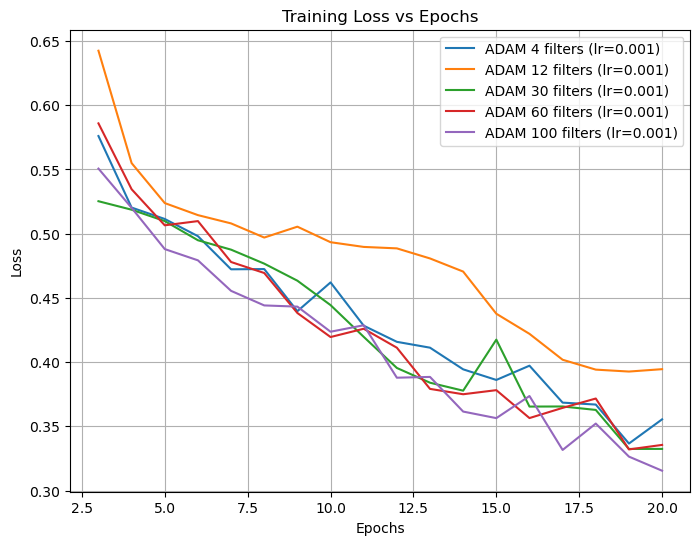

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

results_path = "models_results/" + "4x20x0.001xAdamx1560_27-56-19-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 4 filters", start_epoch=3)
results_path = "models_results/" + "12x20x0.001xAdamx1560_06-35-20-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 12 filters", start_epoch=3)
results_path = "models_results/" + "30x20x0.001xAdamx1560_21-58-20-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 30 filters", start_epoch=3)
results_path = "models_results/" + "60x20x0.001xAdamx1560_54-21-21-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 60 filters", start_epoch=3)
results_path = "models_results/" + "100x20x0.001xAdamx1560_52-45-21-27-12-2024.json"
plot_training_results(ax, results_path, label_prefix="ADAM 100 filters", start_epoch=3)

plt.title("Training Loss vs Epochs")
plt.show()